# Transfer learning with tensorflow part 2: fine-tuning

In the previous notbook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learnin: fine-tuning

In [ ]:
# Check if we are using a GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# A little tidbit I added to run my own GPU in case google is a bitch
import tensorflow as tf
print('Num avaliable GPUs:', len(tf.config.experimental.list_physical_devices('GPU')))

Num avaliable GPUs: 1


## Creating helper functions

In previous notebooks we created a bunch of helper functions, we could rewrite them but this is tedious

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=f998b2bfae71ea5847085eb348b8b3770f05fc92762478b44df21d2fd0e2a459
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-17 08:56:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-17 08:56:08 (98.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem and apply them to our own problem. 

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes 
# !wget 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip' # <--Using local resources. For colab resources uncomment
unzip_data('10_food_classes_10_percent.zip')

In [ ]:
# Creating training and test directory paths

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
# Check out the class names of our dataset 
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight forward (pun intended) it runs our layers sequentially

The functional API gives us more flexibility with our models.

Link - https://www.tensorflow.org/guide/keras/functional

In [ ]:
pip search cudatoolkit

Note: you may need to restart the kernel to use updated packages.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


In [ ]:
# Just for me; creating a callback from tensorboard
import datetime
log_dir = 'Tensorboards/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
# 1. Create base model with tf.keras.application
base_model_0 = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model_0.trainable =  False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using a model like ResNet50V2 you will need to normalize inputs dont have to technically here 
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after globalaveragepooling2d {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs) 

# 9. Compile the model
'''model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model on the training data
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        validation_data=test_data,
                        callbacks=tensorboard_callback)
                        '''

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after globalaveragepooling2d (None, 1280)


"model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),\n                optimizer=tf.keras.optimizers.Adam(),\n                metrics=['accuracy'])\n\n# 10. Fit the model on the training data\nhistory_0 = model_0.fit(train_data_10_percent,\n                        epochs=5,\n                        validation_data=test_data,\n                        callbacks=tensorboard_callback)\n                        "

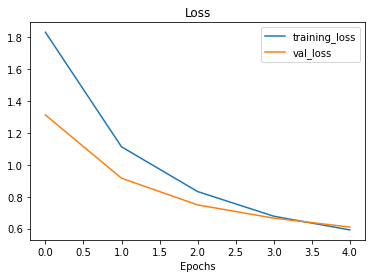

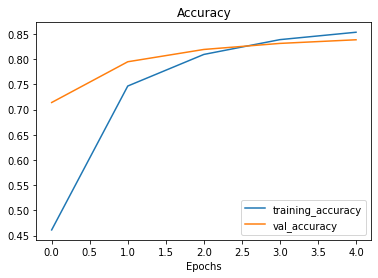

In [ ]:
plot_loss_curves(history_0)

In [ ]:
# Check the layers in our base_model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [ ]:
# Summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_____________________________________________________________________________________

In [ ]:
# How about a summary of our whole model
model_0.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


A note for myself:

This is the same as using hub. But this uses the functional API instead. SO we only train on output layer and not the whole thing as I previously thought.

## Getting a feature vector from a trained model

Let's demostrate the global average pooling layer. 

We have a tesnor after our model goes through 'base_model' of shape (None, 7, 7, 1280)

But then when it passes through GlobalAveragePooling2D, it turns to (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it through GlobalAveragePooling2D

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [ ]:
# Pass the random tensor through the global pooling
global_average_pooling = tf.keras.layers.GlobalAveragePooling2D(name='testing')(input_tensor)
global_average_pooling.shape

TensorShape([1, 3])

In [ ]:
# Visualize the new tensor
print(global_average_pooling)

tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)


The GlobalAveragePooling2D makes a feature vector. Basically flattens it into a vector. How this is done is a mystery, but I gues maths. Ahh I understand, all it does is takes the middle dimensions and averages those and returns that.

In [ ]:
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments 

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. 'model1' - use feature extraction transfer learning with 1% of the training data with data augmentation
2. 'model2' - use feature extraction transfer learning with 10% of the training data with data augmentation
3. 'model3' - use fine-tuning transfer learning with 110% of training data with data augmentation
4. 'model4' - use fine-tuning transfer learning on 100% of the training data with data augmentation.

Note: throughout all experiments the same test data set will be used to evaluate oour model, this ensures consistency across evaluation metrics.

In [ ]:
# Since I run locate I download to my computer instead of doing it here as in the video
train_dir_1_percent = '10_food_classes_1_percent/train/'
test_dir = '10_food_classes_1_percent/test/'

In [ ]:
# Setup data_loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical',
                                                                           batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=32)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Try data_augmentation on your own and build model_1 by yourself

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# Here is the augmentation, above he did rescaling
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs) <- I am stupid, it is already rescaled
#print(f'Shape right after rescaling: {x.shape}')

x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')(inputs)
print(f'Shape right after RandomFlip: {x.shape}')
x = tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)(x)
print(f'Shape right after RandomZoom: {x.shape}')
x = tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(0.2, 0.2))(x)
print(f'Shape right after all preprocessing: {x.shape}')


# Send through the base_model
x = base_model(x)
print(f'Input shape into the model: {x.shape}')

# Global average pool
x = tf.keras.layers.GlobalAveragePooling2D(name='Global_average_pooling_layer')(x)
print(f'Shape after globalavgpooling: {x.shape}')

# Feed through dense layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Take this and feed it through the Model method
model_1 = tf.keras.Model(inputs, outputs)

Shape right after RandomFlip: (None, 224, 224, 3)
Shape right after RandomZoom: (None, 224, 224, 3)
Shape right after all preprocessing: (None, None, 224, 3)
Input shape into the model: (None, None, 7, 1280)
Shape after globalavgpooling: (None, 1280)


In [ ]:
# Compile and fit the model
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=create_tensorboard_callback('Tensorboards', '1_percent_me_test'))

Saving TensorBoard log files to: Tensorboards/1_percent_me_test/20220114-132252
Epoch 1/5


c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 19s 7s/step - loss: 2.3425 - accuracy: 0.1429 - val_loss: 2.2367 - val_accuracy: 0.1804
Epoch 2/5
3/3 [==============================] - 14s 7s/step - loss: 2.1162 - accuracy: 0.2714 - val_loss: 2.0972 - val_accuracy: 0.2680
Epoch 3/5
3/3 [==============================] - 14s 7s/step - loss: 1.8383 - accuracy: 0.5571 - val_loss: 1.9824 - val_accuracy: 0.3504
Epoch 4/5
3/3 [==============================] - 14s 7s/step - loss: 1.7145 - accuracy: 0.5714 - val_loss: 1.8793 - val_accuracy: 0.4184
Epoch 5/5
3/3 [==============================] - 14s 7s/step - loss: 1.5284 - accuracy: 0.6571 - val_loss: 1.7896 - val_accuracy: 0.4728


My own experimentation didn't work well, even taking away all the augmentation. It looks like 1% of the data is not enough 

**Note**: I did rescale the thing twice, after running it one more time it ran better. Even with all the augmentation I did.

In [ ]:
# His way
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotation, zooms, etc

data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2)
], name='data_augmentation')



Putting augmentation in a model benefits from gpu. 

Link: https://www.tensorflow.org/tutorials/images/data_augmentation

### Visualize our data augmentation layer

In [ ]:
# Test data_augmentation on our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(target_class)

NameError: ignored

In [ ]:
print(img[..., np.newaxis].shape)


In [ ]:
# Now let's plot our augmented radnom image
import numpy as np
augmented_picture = data_augmentation(tf.expand_dims(img, axis=0)) / 255.
plt.figure()
plt.imshow(tf.squeeze(augmented_picture))
plt.axis('off')

## Model 1: Feature extraction transfer learning 1% of the training data

In [ ]:
# Setup the input shape and the base model, freezing the base model layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

# Add data augmentation
x = data_augmentation(inputs)
print(f'Shape after augmentation: {x.shape}')

# Send it trough the model but dont train it
x = base_model(x, training=False)
print(f'Shape after through base_model: {x.shape}')

# Send it global avg pool
x = layers.GlobalAveragePooling2D()(x)
print(f'Shape after pooling: {x.shape}')

# Send it through a dense layer
outputs = layers.Dense(10, activation='softmax', name='output_layers')(x)

# Send it through model
model_2 = keras.Model(inputs, outputs)

Shape after augmentation: (None, None, None, 3)
Shape after through base_model: (None, None, None, 1280)
Shape after pooling: (None, 1280)


In [ ]:
# Compile and fit the model
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_2 = model_2.fit(train_data_1_percent,
                        epochs=5,
                        validation_data=test_data,
                        callbacks=create_tensorboard_callback('Tensorboards', '1percent_with_thedude'))

Saving TensorBoard log files to: Tensorboards/1percent_with_thedude/20220114-151444
Epoch 1/5


c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 22s 8s/step - loss: 2.3101 - accuracy: 0.1571 - val_loss: 2.2376 - val_accuracy: 0.1824
Epoch 2/5
3/3 [==============================] - 15s 7s/step - loss: 2.0812 - accuracy: 0.3143 - val_loss: 2.1284 - val_accuracy: 0.2576
Epoch 3/5
3/3 [==============================] - 16s 8s/step - loss: 1.8840 - accuracy: 0.4714 - val_loss: 2.0351 - val_accuracy: 0.3020
Epoch 4/5
3/3 [==============================] - 15s 7s/step - loss: 1.7466 - accuracy: 0.6286 - val_loss: 1.9466 - val_accuracy: 0.3488
Epoch 5/5
3/3 [==============================] - 16s 8s/step - loss: 1.5786 - accuracy: 0.7571 - val_loss: 1.8624 - val_accuracy: 0.3968


In [ ]:
model_2.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, None)  0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
output_layers (Dense)        (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


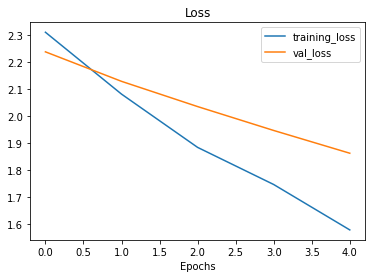

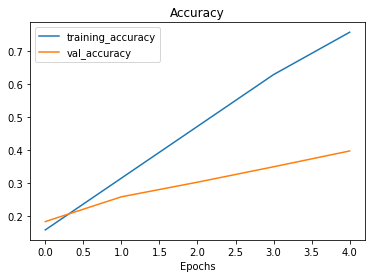

In [ ]:
plot_loss_curves(history_2)

I try myself to do it on the 10% of training data myself before I watch the dude

In [ ]:
# Do the same with 10 percent
train_10_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_data_10_percent_aug = keras.preprocessing.image_dataset_from_directory(train_10_dir,
                                                                             image_size=IMG_SIZE,
                                                                             batch_size=32,
                                                                             label_mode='categorical')

test_data = keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             image_size=IMG_SIZE,
                                                             batch_size=32,
                                                             label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Set up augmentation

data_augmentation_10 = keras.Sequential([
                                         preprocessing.RandomFlip('horizontal'),
                                         preprocessing.RandomHeight(0.2),
                                         preprocessing.RandomWidth(0.2),
                                         preprocessing.RandomZoom(0.2)
                                         #preprocessing.RandomCrop(0.2, 0.2)
], name='data_augmentation')

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

x = data_augmentation_10(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='pooling_layers')(x)

outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_3 = keras.Model(inputs, outputs)


In [ ]:
# Compile and train model

model_3.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_3 = model_3.fit(train_data_10_percent_aug,
                        epochs=5,
                        validation_data=test_data,
                        callbacks=create_tensorboard_callback('Tensorboards', '10_percent_selv_aug'))

Saving TensorBoard log files to: Tensorboards/10_percent_selv_aug/20220114-154619
Epoch 1/5


c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 36s 1s/step - loss: 1.9444 - accuracy: 0.3613 - val_loss: 1.4110 - val_accuracy: 0.6752
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.2346 - accuracy: 0.7120 - val_loss: 0.9767 - val_accuracy: 0.7900
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.9421 - accuracy: 0.7720 - val_loss: 0.7939 - val_accuracy: 0.8132
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.7557 - accuracy: 0.8253 - val_loss: 0.6959 - val_accuracy: 0.8264
Epoch 5/5
24/24 [==============================] - 28s 1s/step - loss: 0.6739 - accuracy: 0.8347 - val_loss: 0.6384 - val_accuracy: 0.8352


## Model 2 feature extraction transfer learning model with 10% of data and augmentation

This is his example in the video. I mostly write it myself, but I ultimately change it to what he does.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from helper_functions import *

In [ ]:
train_dir_10 = '10_food_classes_10_percent/train/'
test_dir_10 = '10_food_classes_10_percent/test/'

In [ ]:
train_data_10_percent_aug = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10,
                                                                                image_size=(224, 224),
                                                                                label_mode='categorical',
                                                                                )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10,
                                                                image_size=(224, 224),
                                                                label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model 2 with data augmentation built in

data_augmentation_10_new = keras.Sequential([
                                             preprocessing.RandomFlip('horizontal'),
                                             preprocessing.RandomHeight(0.2),
                                             preprocessing.RandomWidth(0.2),
                                             preprocessing.RandomZoom(0.2),
                                             preprocessing.RandomRotation(0.2)
], name='data_augmentation_layer')


In [ ]:
# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create frozen layer
base_model_3 = keras.applications.EfficientNetB0(include_top=False)

base_model_3.trainable = False

# Input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Augmentation
x = data_augmentation_10_new(inputs)

# Send it throug the model
x = base_model_3(x, training=False)

# Global pooling
x = layers.GlobalAveragePooling2D()(x)

# Send it through and output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Use model
model_4 = keras.Model(inputs, outputs)

He talks about batch normalization + he wanted to add tensorflow callback saving during training

In [ ]:
checkpoint_filepath = 'checkpoint_for_yo_mama'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

### Fit the model 2 passing in the ModelCheckpoint callback

In [ ]:
# Compile and fit the model
model_4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_4 = model_4.fit(train_data_10_percent_aug,
                        epochs=5,
                        validation_data=test_data,
                        callbacks=[create_tensorboard_callback('Tensorboards', '10_percentage_his_way'), model_checkpoint_callback])

Saving TensorBoard log files to: Tensorboards/10_percentage_his_way/20220116-135415
Epoch 1/5
24/24 [==============================] - 32s 1s/step - loss: 1.3641 - accuracy: 0.6587 - val_loss: 1.0196 - val_accuracy: 0.7540
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 1.0242 - accuracy: 0.7467 - val_loss: 0.8247 - val_accuracy: 0.7924
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.8699 - accuracy: 0.7853 - val_loss: 0.7196 - val_accuracy: 0.8128
Epoch 4/5
24/24 [==============================] - 28s 1s/step - loss: 0.7577 - accuracy: 0.7933 - val_loss: 0.6708 - val_accuracy: 0.8104
Epoch 5/5
24/24 [==============================] - 43s 2s/step - loss: 0.7115 - accuracy: 0.8173 - val_loss: 0.6248 - val_accuracy: 0.8224


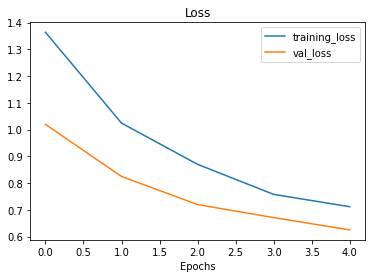

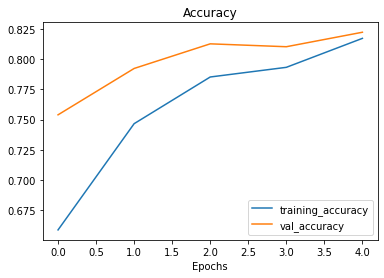

In [ ]:
plot_loss_curves(history_4)

### Loading in checkpointed weights

Loading a checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights and evaluate model
model_4.load_weights(checkpoint_filepath)

In [ ]:
# Evaluate model_4 with loaded weights
loaded_weights_model_results = model_4.evaluate(test_data)

79/79 [==============================] - 14s 171ms/step - loss: 0.6248 - accuracy: 0.8224


In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
#np.isclose(np.array(loaded_weights_model_results), and then add the other here)

## His model 3 (my model 5). Fine tuning with transfer learning

Top layers are refered to as the last layers in the network. We are going to unfreezse them now, meaning we can train the parameters in these layers. The number of layers we unfreeze is arbritrary.

**Note:** FIne-tuning usually works best after a feature extraction model for a few epochs with a large amount of custom data.

In [ ]:
# Layers in our loaded model
model_4.layers

In [ ]:
for layer in model_4.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001C9BEC2FBC8> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001C9BEFC0388> True
<tensorflow.python.keras.engine.functional.Functional object at 0x000001C9BF4850C8> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x000001C9C625B488> True
<tensorflow.python.keras.layers.core.Dense object at 0x000001C9C9EE4E48> True


In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_4.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# How many trainable variable are in our base model?
print(len(model_4.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, lets start by setting the last 10 layers of our base_mode.trainable = True
base_model_3.trainable = True

# Freeze all layers except for the last 10
for layer in base_model_3.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change (duh))
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # When fine-tuning you typically want to lower to lr by 10X
                metrics=['accuracy'])

c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Good practice to lower learning rate by a certain amount.

Paper on it that is good: https://arxiv.org/abs/1801.06146

In [ ]:
# Check which layers are tunable
for layer_number, layer in enumerate(model_4.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Now we have unfrozen some of the layers closer to the top. How many trainable variables
print(len(model_4.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs

fine_tune_epochs = 5 + 5

# Refit the model
history_4_v2 = model_4.fit(train_data_10_percent_aug,
                           epochs=fine_tune_epochs,
                           validation_data=test_data,
                           initial_epoch=history_4.epoch[-1], # start training from prvious last epoch
                           callbacks=[create_tensorboard_callback('Tensorboards', '10_percent_fine_tuning'), model_checkpoint_callback])

Saving TensorBoard log files to: Tensorboards/10_percent_fine_tuning/20220116-145010


c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
24/24 [==============================] - 24s 991ms/step - loss: 0.5305 - accuracy: 0.8320 - val_loss: 0.5202 - val_accuracy: 0.8284
Epoch 6/10
24/24 [==============================] - 25s 1s/step - loss: 0.4663 - accuracy: 0.8720 - val_loss: 0.4980 - val_accuracy: 0.8304
Epoch 7/10
24/24 [==============================] - 24s 992ms/step - loss: 0.4343 - accuracy: 0.8667 - val_loss: 0.4999 - val_accuracy: 0.8320
Epoch 8/10
24/24 [==============================] - 25s 1s/step - loss: 0.3599 - accuracy: 0.8867 - val_loss: 0.4935 - val_accuracy: 0.8336
Epoch 9/10
24/24 [==============================] - 48s 2s/step - loss: 0.3345 - accuracy: 0.9080 - val_loss: 0.4895 - val_accuracy: 0.8352
Epoch 10/10
24/24 [==============================] - 35s 1s/step - loss: 0.2987 - accuracy: 0.9187 - val_loss: 0.4930 - val_accuracy: 0.8332


In [ ]:
result_fine_tune_10_percent = model_4.evaluate(test_data)

79/79 [==============================] - 14s 171ms/step - loss: 0.4930 - accuracy: 0.8332


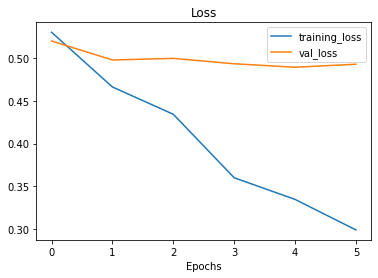

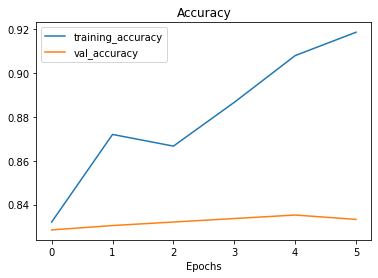

In [ ]:
plot_loss_curves(history_4_v2)

In [ ]:
# Let's make a comparisson
def compare_historys(original_history, new_history, initial_epochs=5):

  total_acc = original_history.history['accuracy'] + new_history.history['accuracy']
  total_loss = original_history.history['loss'] + new_history.history['loss']

  total_val_acc = original_history.history['val_accuracy'] + new_history.history['val_accuracy']
  total_val_loss = original_history.history['val_loss'] + new_history.history['val_loss']

  # Plot the figures:
  plt.figure(figsize=(15, 12))
  plt.subplot(1, 2, 1)
  plt.plot(total_loss, label='training loss')
  plt.plot(total_val_loss, label='validation loss')
  #plt.vlines(ymin=0.2, ymax=1.5, x=5, linestyles='dotted')
  plt.plot([4, 4], plt.ylim(), label='Start fine tuning')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(total_acc, label='training accuracy')
  plt.plot(total_val_acc, label='validation accuracy')
  #plt.vlines(ymin=0.7, ymax=1, x=5, linestyles='dotted')
  plt.plot([4, 4], plt.ylim(), label='Start fine tuning')
  plt.legend()

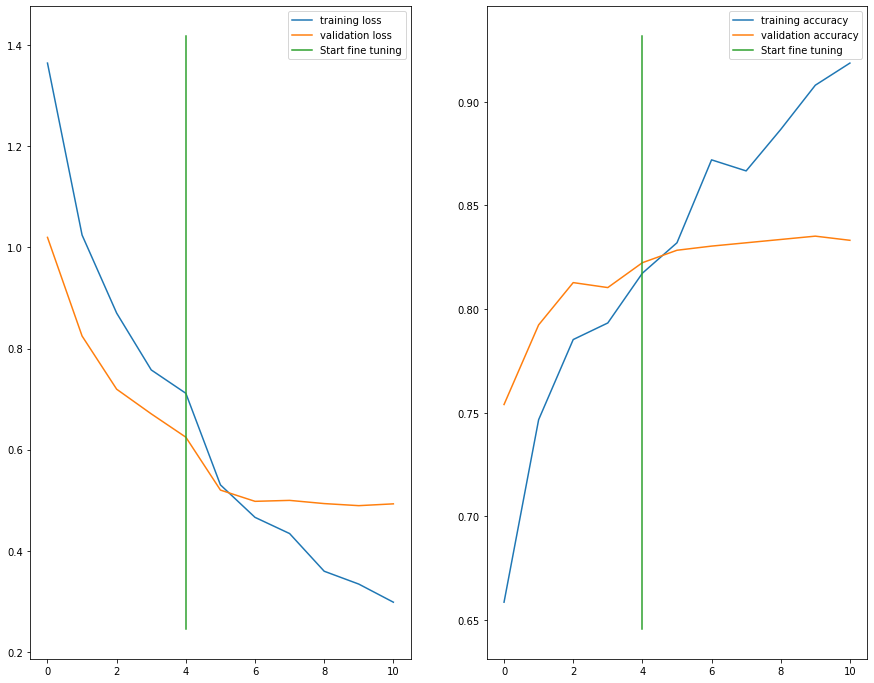

In [ ]:
compare_historys(history_4, history_4_v2)

## Model4: Fine-tuning an existing model with all training data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data('10_food_classes_all_data.zip')

--2022-01-17 08:25:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   115MB/s    in 4.6s    

2022-01-17 08:25:28 (109 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
full_train_dir = '10_class/train/'
full_test_dir = '10_class/test/'

In [ ]:
full_train_data = tf.keras.preprocessing.image_dataset_from_directory(full_train_dir,
                                                                      image_size=(224, 224),
                                                                      label_mode='categorical',
                                                                      )

test_data = tf.keras.preprocessing.image_dataset_from_directory(full_test_dir,
                                                                image_size=(224, 224),
                                                                label_mode='categorical')

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test data has been the same since the start

In [ ]:
full_data_augmentation = tf.keras.Sequential([
                                              layers.experimental.preprocessing.RandomRotation(0.2),
                                              layers.experimental.preprocessing.RandomHeight(0.2),
                                              layers.experimental.preprocessing.RandomFlip('horizontal'),
                                              layers.experimental.preprocessing.RandomWidth(0.2),
                                              layers.experimental.preprocessing.RandomZoom(0.2)
], name='full_layer_augmentation')

In [ ]:
full_base_model = tf.keras.applications.EfficientNetB0(include_top=False)

full_base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

x = full_data_augmentation(inputs)

x = full_base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='Global_average_pooling_layer')(x)

outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_5 = tf.keras.Model(inputs, outputs)

In [ ]:
model_5.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

full_history = model_5.fit(full_train_data,
                           epochs=5,
                           validation_data=test_data,
                           callbacks=[create_tensorboard_callback('Tensorboards', 'full_data_thingy'), model_checkpoint_callback])

Saving TensorBoard log files to: Tensorboards/full_data_thingy/20220116-190744
Epoch 1/5


c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 120s 493ms/step - loss: 1.1008 - accuracy: 0.6713 - val_loss: 0.5235 - val_accuracy: 0.8508
Epoch 2/5
235/235 [==============================] - 108s 456ms/step - loss: 0.6865 - accuracy: 0.7879 - val_loss: 0.4350 - val_accuracy: 0.8628
Epoch 3/5
235/235 [==============================] - 100s 421ms/step - loss: 0.6124 - accuracy: 0.8079 - val_loss: 0.3986 - val_accuracy: 0.8736
Epoch 4/5
235/235 [==============================] - 127s 539ms/step - loss: 0.5675 - accuracy: 0.8215 - val_loss: 0.3927 - val_accuracy: 0.8748
Epoch 5/5
235/235 [==============================] - 115s 477ms/step - loss: 0.5402 - accuracy: 0.8271 - val_loss: 0.3766 - val_accuracy: 0.8800


In [ ]:
# To begin fine-tuning, lets start by setting the last 10 layers of our base_mode.trainable = True
base_model_3.trainable = True

# Freeze all layers except for the last 10
for layer in base_model_3.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change (duh))
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # When fine-tuning you typically want to lower to lr by 10X
                metrics=['accuracy'])

In [ ]:
full_base_model.trainable = True

for layer in full_base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
model_5.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                        metrics=['accuracy'])

c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
full_tunable_history = model_5.fit(full_train_data,
                                   epochs=10,
                                   validation_data=test_data,
                                   validation_steps=(0.25*len(test_data)),
                                   initial_epoch=5,
                                   callbacks=[create_tensorboard_callback('Tensorboards', 'tuned_on_full_data'), model_checkpoint_callback])

Saving TensorBoard log files to: Tensorboards/tuned_on_full_data/20220116-192432
Epoch 6/10


c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 73s 287ms/step - loss: 0.4970 - accuracy: 0.8383 - val_loss: 0.3392 - val_accuracy: 0.8797
Epoch 7/10
235/235 [==============================] - 74s 313ms/step - loss: 0.4452 - accuracy: 0.8561 - val_loss: 0.3206 - val_accuracy: 0.8906
Epoch 8/10
235/235 [==============================] - 77s 324ms/step - loss: 0.4037 - accuracy: 0.8709 - val_loss: 0.3360 - val_accuracy: 0.8781
Epoch 9/10
235/235 [==============================] - 86s 362ms/step - loss: 0.3748 - accuracy: 0.8788 - val_loss: 0.3554 - val_accuracy: 0.8687
Epoch 10/10
235/235 [==============================] - 90s 380ms/step - loss: 0.3301 - accuracy: 0.8920 - val_loss: 0.3358 - val_accuracy: 0.8734


To train a fine-tuning model we need to revert model_2 back to its feature extraction weights. I will run another experiment and then load from the model_checkpoint

In [ ]:
from helper_functions import *

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data('10_food_classes_10_percent.zip')

--2022-01-17 08:56:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.96.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   214MB/s    in 0.8s    

2022-01-17 08:56:36 (214 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [ ]:
import tensorflow as tf
img_size = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=img_size)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=img_size)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Make data agumentation

data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                                         tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
                                         tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
], name='data_aumentation')

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=img_size+(3,), name='input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model_6 = tf.keras.Model(inputs, outputs, name='output_layer')

16719872/16705208 [==============================] - 1s 0us/step


In [ ]:
# Create model checkpoint
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/checkpoint',
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         mode='max',
                                                         monitor='val_accuracy')


In [ ]:
# Compile and train the model
model_6.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_6 = model_6.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback('Tensorboard', 'model_6'), checkpoint_callback])

Saving TensorBoard log files to: Tensorboard/model_6/20220117-085645
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 27s 523ms/step - loss: 2.0759 - accuracy: 0.3053 - val_loss: 1.5486 - val_accuracy: 0.6516
Epoch 2/5
24/24 [==============================] - 11s 443ms/step - loss: 1.3998 - accuracy: 0.6667 - val_loss: 1.0930 - val_accuracy: 0.7656
Epoch 3/5
24/24 [==============================] - 8s 339ms/step - loss: 1.1004 - accuracy: 0.7333 - val_loss: 0.8798 - val_accuracy: 0.7953
Epoch 4/5
24/24 [==============================] - 9s 382ms/step - loss: 0.9379 - accuracy: 0.7600 - val_loss: 0.7705 - val_accuracy: 0.8203
Epoch 5/5
24/24 [==============================] - 9s 363ms/step - loss: 0.8111 - accuracy: 0.7920 - val_loss: 0.7057 - val_accuracy: 0.8109


79/79 [==============================] - 7s 77ms/step - loss: 0.7097 - accuracy: 0.8096


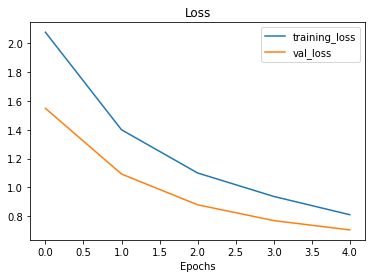

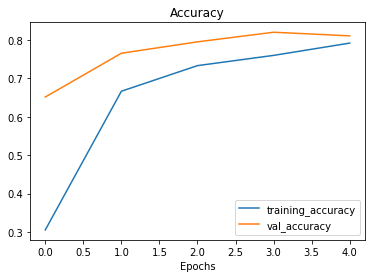

In [ ]:
pre_fine_tune_evaluate = model_6.evaluate(test_data)
plot_loss_curves(history_6)

In [ ]:
model_6.load_weights('/tmp/checkpoint')

In [ ]:
loaded_evaluate = model_6.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.7717 - accuracy: 0.8156


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data('10_food_classes_all_data.zip')

--2022-01-17 09:02:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   102MB/s    in 4.8s    

2022-01-17 09:02:39 (102 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
full_train_path = '10_food_classes_all_data/train/'
test_dir = '10_food_classes_all_data/test/'

In [ ]:
full_train_data = tf.keras.preprocessing.image_dataset_from_directory(full_train_path,
                                                                      image_size=img_size,
                                                                      label_mode='categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=img_size,
                                                                label_mode='categorical')

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
base_model.trainable = True

for number, layer in enumerate(base_model.layers):
  print(number, layer.name)

In [ ]:
# Put the last 10 layers to trainable

for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
# Check if we did it correctly

for i, layer in enumerate(base_model.layers):
  print(i, layer.trainable)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False


In [ ]:
# Compile and train the model again. Set lr to low

model_6.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

history_6_v2 = model_6.fit(full_train_data,
                           epochs=10,
                           validation_data=test_data,
                           validation_steps=(0.25*len(test_data)),
                           initial_epoch=5,
                           callbacks=[create_tensorboard_callback('Tensorboard', 'model_6_v2'), checkpoint_callback])

Saving TensorBoard log files to: Tensorboard/model_6_v2/20220117-091909
Epoch 6/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


235/235 [==============================] - 65s 247ms/step - loss: 0.7409 - accuracy: 0.7657 - val_loss: 0.4274 - val_accuracy: 0.8625
Epoch 7/10
235/235 [==============================] - 49s 208ms/step - loss: 0.5957 - accuracy: 0.8061 - val_loss: 0.3884 - val_accuracy: 0.8719
Epoch 8/10
235/235 [==============================] - 48s 201ms/step - loss: 0.5328 - accuracy: 0.8287 - val_loss: 0.3485 - val_accuracy: 0.8875
Epoch 9/10
235/235 [==============================] - 42s 179ms/step - loss: 0.4867 - accuracy: 0.8449 - val_loss: 0.3409 - val_accuracy: 0.8922
Epoch 10/10
235/235 [==============================] - 43s 179ms/step - loss: 0.4515 - accuracy: 0.8544 - val_loss: 0.3266 - val_accuracy: 0.9062


He is writing a lot, but the basic jizz is that we have fine tuned a model on the same data. 10 percent and 10 percent. But now I have used 100% of the training data. When training on the top layers we learn smaller features. The idea is that when we fine tune on more data we learn better the smaller level featers

79/79 [==============================] - 6s 71ms/step - loss: 0.3231 - accuracy: 0.8960


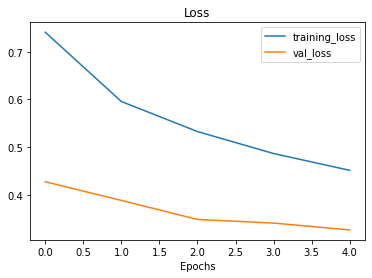

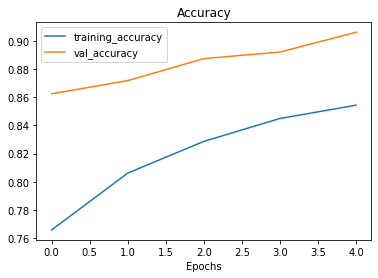

In [ ]:
fine_tuned_evaluation = model_6.evaluate(test_data)
plot_loss_curves(history_6_v2)

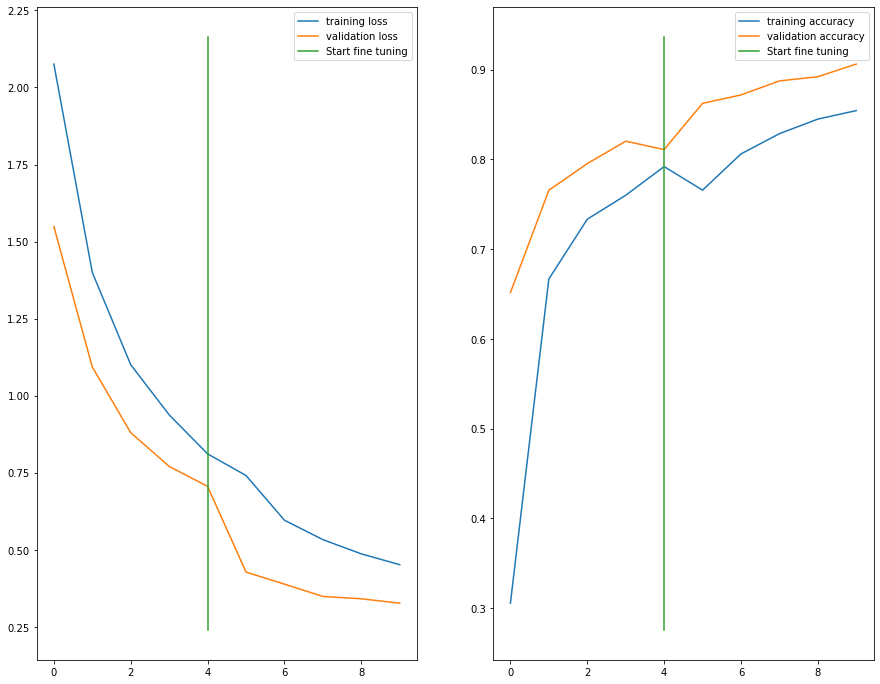

In [ ]:
# Compare history 
compare_historys(history_6, history_6_v2)

# Extra tasks

In [ ]:
import tensorflow as tf
from helper_functions import *

In [ ]:
# Task 1
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [ ]:
img_size = (224, 224)
train_data_tasks = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                       image_size=img_size,
                                                                       label_mode='categorical')
test_data_tasks = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                      image_size=img_size,
                                                                      label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Data augmentation 
data_augmentation_layer = tf.keras.Sequential([
                                               tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                               tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
                                               tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
                                               tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                                               tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
], name='augmentation')

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=img_size+(3,), name='input')

x = data_augmentation_layer(inputs)

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(10, activation='softmax', name='output')(x)

task_model = tf.keras.Model(inputs, outputs)

In [ ]:
def checkpoint_callback(filename):

  return tf.keras.callbacks.ModelCheckpoint(
      filename,
      monitor='val_accuracy',
      save_weights_only=True,
      mode='max',
      save_best_only=True
  )

In [ ]:
# Compile and train the model
task_model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

task_history = task_model.fit(train_data_tasks,
                              epochs=10,
                              validation_data=test_data_tasks,
                              validation_steps=(0.25*len(test_data_tasks)),
                              callbacks=[create_tensorboard_callback('Tensorboards', 'Extra_tasks'), checkpoint_callback('Task_1')])

Saving TensorBoard log files to: Tensorboards/Extra_tasks/20220117-151228
Epoch 1/10


c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 46s 917ms/step - loss: 2.0618 - accuracy: 0.2880 - val_loss: 1.5189 - val_accuracy: 0.6641
Epoch 2/10
24/24 [==============================] - 15s 629ms/step - loss: 1.3940 - accuracy: 0.6320 - val_loss: 1.0679 - val_accuracy: 0.7953
Epoch 3/10
24/24 [==============================] - 15s 616ms/step - loss: 1.0774 - accuracy: 0.7387 - val_loss: 0.8421 - val_accuracy: 0.8125
Epoch 4/10
24/24 [==============================] - 14s 581ms/step - loss: 0.9307 - accuracy: 0.7693 - val_loss: 0.7605 - val_accuracy: 0.8156
Epoch 5/10
24/24 [==============================] - 14s 566ms/step - loss: 0.8191 - accuracy: 0.7773 - val_loss: 0.7018 - val_accuracy: 0.8234
Epoch 6/10
24/24 [==============================] - 14s 599ms/step - loss: 0.7412 - accuracy: 0.8053 - val_loss: 0.6583 - val_accuracy: 0.8172
Epoch 7/10
24/24 [==============================] - 13s 558ms/step - loss: 0.6654 - accuracy: 0.8373 - val_loss: 0.6213 - val_accuracy: 0.8125
Epoch 8/10

79/79 [==============================] - 16s 194ms/step - loss: 0.5678 - accuracy: 0.8336


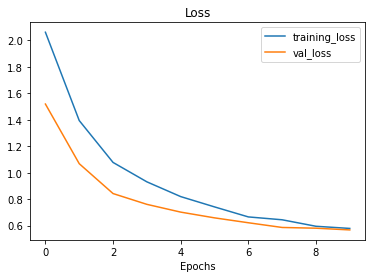

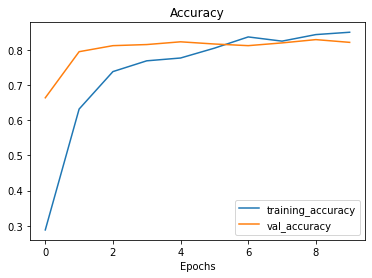

In [ ]:
pre_fine_tune_evaluate = task_model.evaluate(test_data_tasks)
plot_loss_curves(task_history)

In [ ]:
task_model.load_weights('Task_1')

In [ ]:
# Loaded in the best epoch
best_epoch_evaluate = task_model.evaluate(test_data_tasks)

79/79 [==============================] - 13s 166ms/step - loss: 0.5726 - accuracy: 0.8360


## Fine tune the last 20 layers

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
  layer.trainable = False

In [ ]:
v_step = 0.25*len(test_data_tasks)

In [ ]:
# Compile and fit again
task_model.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

task_history_v2 = task_model.fit(train_data_tasks,
                                 epochs=20,
                                 validation_data=test_data_tasks,
                                 validation_steps=v_step,
                                 initial_epoch=10,
                                 callbacks=[create_tensorboard_callback('Tensorboards', 'Extra_tasks'), checkpoint_callback('Task_1_2')])

Saving TensorBoard log files to: Tensorboards/Extra_tasks/20220117-152944
Epoch 11/20


c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 28s 508ms/step - loss: 0.7958 - accuracy: 0.7480 - val_loss: 0.6157 - val_accuracy: 0.8047
Epoch 12/20
24/24 [==============================] - 14s 581ms/step - loss: 0.3455 - accuracy: 0.8747 - val_loss: 0.5320 - val_accuracy: 0.8391
Epoch 13/20
24/24 [==============================] - 13s 548ms/step - loss: 0.1989 - accuracy: 0.9333 - val_loss: 0.5896 - val_accuracy: 0.8266
Epoch 14/20
24/24 [==============================] - 14s 550ms/step - loss: 0.1661 - accuracy: 0.9427 - val_loss: 0.6059 - val_accuracy: 0.8203
Epoch 15/20
24/24 [==============================] - 14s 590ms/step - loss: 0.1190 - accuracy: 0.9693 - val_loss: 0.6203 - val_accuracy: 0.8313
Epoch 16/20
24/24 [==============================] - 13s 534ms/step - loss: 0.1494 - accuracy: 0.9427 - val_loss: 0.7078 - val_accuracy: 0.8109
Epoch 17/20
24/24 [==============================] - 13s 519ms/step - loss: 0.0930 - accuracy: 0.9733 - val_loss: 0.5398 - val_accuracy: 0.8469
Epoc

In [ ]:
fine_tuned_10_epochs = task_model.evaluate(test_data_tasks)

79/79 [==============================] - 13s 165ms/step - loss: 0.6855 - accuracy: 0.8408


In [ ]:
task_model.load_weights('Task_1_2')

In [ ]:
best_epoch_fine_tuned_10_epoch = task_model.evaluate(test_data_tasks)

79/79 [==============================] - 14s 167ms/step - loss: 0.6504 - accuracy: 0.8332


In [ ]:
for layer in base_model.layers[:-30]:
  layer.trainable = False

In [ ]:
# Compile and fit again
task_model.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])
task_history_v3 = task_model.fit(train_data_tasks,
                                 epochs=30,
                                 validation_data=test_data_tasks,
                                 validation_steps=v_step,
                                 callbacks=[create_tensorboard_callback('Tensorboards', 'Extra_tasks'), checkpoint_callback('Task_1_3')],
                                 initial_epoch=20)

Saving TensorBoard log files to: Tensorboards/Extra_tasks/20220117-154658
Epoch 21/30


c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 13s 402ms/step - loss: 0.0960 - accuracy: 0.9693 - val_loss: 0.7357 - val_accuracy: 0.8125
Epoch 22/30
24/24 [==============================] - 12s 497ms/step - loss: 0.1079 - accuracy: 0.9627 - val_loss: 0.8235 - val_accuracy: 0.8203
Epoch 23/30
24/24 [==============================] - 13s 543ms/step - loss: 0.1320 - accuracy: 0.9627 - val_loss: 0.7538 - val_accuracy: 0.8125
Epoch 24/30
24/24 [==============================] - 12s 494ms/step - loss: 0.0870 - accuracy: 0.9760 - val_loss: 0.6136 - val_accuracy: 0.8250
Epoch 25/30
24/24 [==============================] - 12s 512ms/step - loss: 0.0394 - accuracy: 0.9867 - val_loss: 0.7616 - val_accuracy: 0.8328
Epoch 26/30
24/24 [==============================] - 13s 531ms/step - loss: 0.0202 - accuracy: 0.9960 - val_loss: 0.7609 - val_accuracy: 0.8438
Epoch 27/30
24/24 [==============================] - 12s 514ms/step - loss: 0.0517 - accuracy: 0.9853 - val_loss: 0.7039 - val_accuracy: 0.8250
Epoc